In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
tf.__version__

'2.0.0'

In [4]:
def use_svg_display():
    """Use the svg format to display plot in jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    set_figsize((3.5, 2.5))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

## 简介
在动量法中，有一个明显的弊端-在梯度下降算法中所有的变量都使用同一个学习率，当参数梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。本节我们介绍AdaGrad算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题

## 算法

AdaGrad算法会使用一个小批量随机梯度$g_t$按元素平方的累加变量$s_t$。在时间步0，AdaGrad将$s_0$中每个元素初始化为0。在时间步 t ，首先将小批量随机梯度$g_t$按元素平方后累加到变量$s_t$：
$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$
其中 ⊙ 是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：
$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

### 动手实现
让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$,下面实现基于这个目标函数的梯度下降，并演示使用学习率为 0.4 时自变量的迭代轨迹。

In [6]:
eat = 0.4

def fx(x1,x2):
    return 0.1 * x1**2 + 2 *x2**2

def adagrad_2d(x1,x2,s1,s2):
    d_x1 = 0.2 * x1
    d_x2 = 4.0 * x2
    
    s1 = s1 + d_x1 * d_x1
    s2 = s2 + d_x2 * d_x2
    
    return (x1 -eat/tf.sqrt(s1 + epsilon) * d_x1 ,x2- eat/tf.sqrt(s2 + epsilon) * d_x2,s1,s2)

epoch 20, x1 -2.382565, x2 -0.158591


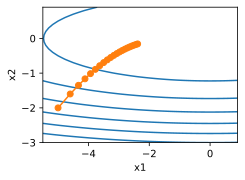

In [7]:
epsilon = 1e-5
show_trace_2d(fx,train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 0.000000


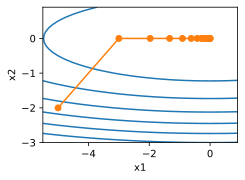

In [8]:
eat = 2
show_trace_2d(fx,train_2d(adagrad_2d))

### 构建数据

In [9]:
def fx(x):
    w = tf.constant([4,-3],dtype=tf.float32)
    
    return tf.reduce_sum(x*w,axis=1)+5.0 + tf.random.normal(shape=(x.shape[0],))

x = tf.random.normal(shape=(1000,2))
y = fx(x)

def create_ds(x,y,batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    return ds.shuffle(1000).batch(batch_size).repeat()

ds = create_ds(x,y,20)

temp_x,temp_y = next(iter(ds))

In [10]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(MyLayer,self).__init__(**kwargs)
        self.w = self.add_weight(name="w",shape=(1,2),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
        self.b = self.add_weight(name="b",shape=(1,),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
    
    def call(self,x):
        return tf.reduce_sum(x * self.w,axis=1,name="sum") + self.b

In [23]:
model = tf.keras.Sequential([
    MyLayer()
])

In [26]:
model.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=0.1))
history = model.fit(ds,epochs=20,steps_per_epoch=100)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 0s 3ms/step - loss: 1.0273 - mae: 0.8072
Epoch 2/20
100/100 [==============================] - 0s 892us/step - loss: 0.9806 - mae: 0.7867
Epoch 3/20
100/100 [==============================] - 0s 892us/step - loss: 0.9635 - mae: 0.7783
Epoch 4/20
100/100 [==============================] - 0s 902us/step - loss: 0.9544 - mae: 0.7737
Epoch 5/20
100/100 [==============================] - 0s 792us/step - loss: 0.9489 - mae: 0.7707
Epoch 6/20
100/100 [==============================] - 0s 862us/step - loss: 0.9453 - mae: 0.7689
Epoch 7/20
100/100 [==============================] - 0s 882us/step - loss: 0.9428 - mae: 0.7677
Epoch 8/20
100/100 [==============================] - 0s 812us/step - loss: 0.9412 - mae: 0.7669
Epoch 9/20
100/100 [==============================] - 0s 822us/step - loss: 0.9399 - mae: 0.7662
Epoch 10/20
100/100 [==============================] - 0s 812us/step - loss: 0.9391 - mae: 0.7658
Epoch 11/20

In [27]:
model.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 3.9703157, -2.947678 ]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([4.978199], dtype=float32)>]